[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/051_gans/gans.ipynb)

# GANs

GANs (*generative adversarial networks*) es una arquitectura de red neuronal propuesta en 2014 por [Ian Goodfellow](https://arxiv.org/pdf/1406.2661.pdf) y otros con el objetivo de obtener modelos capaces de generar datos realistas, principalmente imágenes. Pese a la simplicidad de la idea original, se tardó varios años en superar varias de las dificultades que presenta su entrenamiento. Hoy en día, sin embargo, se utilizan para obtener resultados espectaculares. Algunos ejemplos son:

- Generación de caras: https://www.thispersondoesnotexist.com/
- Generación de anuncios de Airbnb: https://thisrentaldoesnotexist.com/
- Super-resolución: https://www.youtube.com/watch?v=3RYNThid23g
- Colorización: https://github.com/jantic/DeOldify
- Generación de paisajes: http://nvidia-research-mingyuliu.com/gaugan
- Y muchos otros.

## La arquitectura

La arquitectura básica de las *GANs* está formada por dos redes neuronales:

- El **generador**: recibe a la entrada valores aleatorios (normalmente obtenidos de una distribución de tipo gausiana) y da a la salida una imagen. Puedes ver la entrada aleatoria como una representación latente (o codificación) de la imagen generada.
- El **discriminador**: recibe a la entrada una imagen (real o generada por el generador) y tiene que decidir si bien la imagen es real o falsa.

![](https://www.researchgate.net/publication/336781462/figure/fig2/AS:817722363494401@1571971612898/Example-of-a-typical-GANs-architecture-for-both-hand-written-digits-recognition-and.png)

Durante el entrenamiento, el generador y el discriminador compiten entre ellos. Por un lado, el generador intenta generar imágenes cada vez más realistas para poder engañar al discriminador. Por otro lado, el generador cada vez será más bueno diferenciando imágenes reales de las generadas artificialmente por el generador. Esto implica que no podemos entrenar una *GAN* como hemos entrenado el resto de redes neuronales. El objetivo final será el de obtener un generador tan bueno que nuestro discriminador no sea capaz de diferenciar imágenes reales de falsas. Ésto impone unas restricciones muy fuertes en el proceso de entrenamiento, haciendo que sea difícil si no lo hacemos de la forma adecuada.

## El entrenamiento

Para poder entrenar una *GAN* de manera efectiva, lo haremos en dos pasos: 

1. En una primera fase, entrenamos el discriminador. En cada iteración, le daremos un *batch* compuesto de imágenes reales obtenidas del dataset e imágenes falsas generadas por el generador. Definiremos un conjunto de etiquetas a 0 para las imágenes falsas y 1 para las reales. Entonces, optimizaremos el discriminador (utilizando una función de pérdida de tipo *binary cross-entropy* mejorando así sus capacidades de distinguir imágenes falsas de reales.
2. En la segunda fase, entrenamos el generador. En cada iteración, le daremos un *batch* compuesto de ruido aleatorio para que genere imágenes. Estas imágenes son introducidas en el discriminador, cuyas salidas (etiquetas real/falso) con comparadas con un conjunto de etiquetas definidas como reales. Entonces, optimizaremos el generador (utilizando de nuevo la misma función de pérdida) de manera que el generador actualizará sus pesos para generar imágenes que engañen al discriminador.

> 💡 Como puedes observar, el generador nunca llega a ver las imágenes reales. Sin embargo es capaz de generar imágenes realistas simplemente intentando engañar al discriminador. Cuánto mejor sea el discriminador, mejor será el generador.

## GAN simple

Vamos a ver cómo podemos implementar esta arquitectura y proceso de entrenamiento con la implementación de una *GAN* muy simple para generar imágenes del dataset Fashion MNIST.

In [1]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)

classes = ("t-shirt", "trousers", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot")

In [3]:
import numpy as np

class Dataset(torch.utils.data.Dataset):
  def __init__(self, trainset):
    self.imgs = torch.tensor([np.array(i[0]).flatten() / 255. for i in trainset], dtype=torch.float, device=device)
    self.labels = torch.tensor([i[1] for i in trainset], dtype=torch.long, device=device)

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, ix):
    return self.imgs[ix], self.labels[ix]

train = Dataset(trainset)
len(train)

60000

In [4]:
img, label = train[0]
img.shape, img.dtype, img.max(), img.min()

(torch.Size([784]),
 torch.float32,
 tensor(1., device='cuda:0'),
 tensor(0., device='cuda:0'))

In [5]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([32, 784]), torch.Size([32]))

El dataset está formado por 60000 imágenes de baja resolución (28 x 28 píxeles, en blanco y negro) y contiene 10 tipos prendas de ropa (camisetas, pantalones, etc).

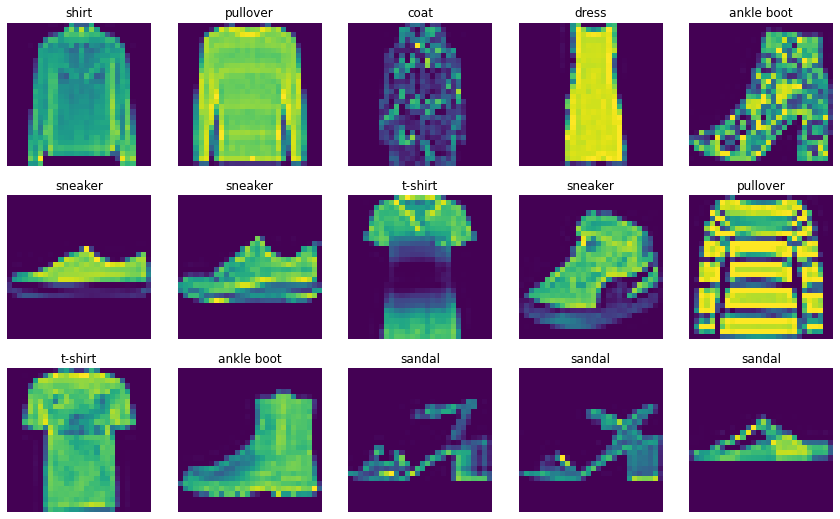

In [6]:
import random 
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(train)-1)
        img, label = train[ix]
        plt.imshow(img.reshape(28,28).cpu())
        plt.axis('off')
        plt.title(classes[label.item()])
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

El objetivo es entrenar una *GAN* que sea capaz de generar imágenes similares a las que tenemos en el dataset a partir de valores aleatorios (ruido). Para ello, como ya hemos visto en las secciones anteriores, necesitamos un **generador** y un **discrimiandor**. Para esta implementación simple usaremos la misma arquitectura para ambas redes, un Perceptrón Multicapa (MLP).

In [7]:
import torch.nn as nn

def block(n_in, n_out):
  return nn.Sequential(
      nn.Linear(n_in, n_out),
      nn.ReLU(inplace=True)
  )

class MLP(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.fc1 = block(input_size, 150)
    self.fc2 = block(150, 100)
    self.fc3 = nn.Linear(100, output_size)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

Nuestro MLP está formado por 3 capas lineales (cada capa seguida de una activación `relu`). En función del número de entradas y salidas definiremos las diferentes redes. Por ejemplo, el generador recibirá un vector con 30 valores aleatorios y nos dará a la salida un vector de 28 x 28 valores (igual que las imágenes del dataset).

In [8]:
n_in, n_out = 30, 28*28
generator = MLP(n_in, n_out)

In [9]:
output = generator(torch.randn(64, 30))
output.shape

torch.Size([64, 784])

Obviamente, nuestro generador inicializado genera imágenes aleatorias que en nada se parecen a las reales.

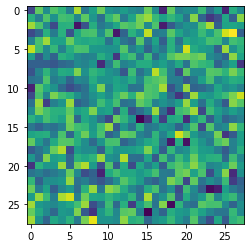

In [10]:
plt.imshow(output[0].reshape(28,28).detach().numpy())
plt.show()

El discriminador, por otro lado, recibirá a la entrada una imagen (28 x 28 valores) y a la salida nos dará una clasificación binaria (real o falso).

In [11]:
discriminator = MLP(28*28, 1)
output = discriminator(torch.randn(64, 28*28))
output.shape

torch.Size([64, 1])

La siguiente función será la responsable de entrenar ambas redes.

In [12]:
from fastprogress import master_bar, progress_bar

def fit(g, d, dataloader, epochs=30, crit=None):
  g.to(device)
  d.to(device)
  g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
  d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)
  crit = nn.BCEWithLogitsLoss() if crit == None else crit
  g_loss, d_loss = [], []
  mb = master_bar(range(1, epochs+1))
  hist = {'g_loss': [], 'd_loss': []}
  for epoch in mb:
    for X, y in progress_bar(dataloader, parent=mb):
      #X, y = X.to(device), y.to(device)  
      # entrenamos el discriminador
      g.eval()
      d.train()
      #   generamos un batch de imágenes falsas
      noise = torch.randn((X.size(0), g.input_size)).to(device)
      genenerated_images = g(noise)
      #   input del discrminator
      d_input = torch.cat([genenerated_images, X.view(X.size(0), -1)])
      #   gorund truth para el discriminator
      d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1,1).to(device)
      #   optimización
      d_optimizer.zero_grad()
      d_output = d(d_input)
      d_l = crit(d_output, d_gt)
      d_l.backward()
      d_optimizer.step()
      d_loss.append(d_l.item())
      # entrenamos el generador
      g.train()
      d.eval()
      #   generamos un batch de imágenes falsas
      noise = torch.randn((X.size(0), g.input_size)).to(device)
      genenerated_images = g(noise)
      #   salidas del discriminador
      d_output = d(genenerated_images)
      #   gorund truth para el generator
      g_gt = torch.ones(X.size(0)).view(-1,1).to(device)
      #   optimización
      g_optimizer.zero_grad()
      g_l = crit(d_output, g_gt)
      g_l.backward()
      g_optimizer.step()
      g_loss.append(g_l.item())
      # logs
      mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
    mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
    hist['g_loss'].append(np.mean(g_loss))    
    hist['d_loss'].append(np.mean(d_loss))
  return hist

In [13]:
hist = fit(generator, discriminator, dataloader)

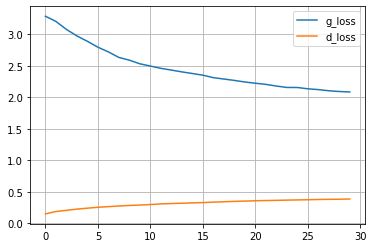

In [14]:
import pandas as pd 

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

Como podemos ver, la *loss* del generador ha ido disminuyendo (lo cual sabemos que es señal de que el entrenamiento ha ido bien y la red ha aprendido a generar buenas imágenes). Sin embargo, la *loss* del discriminador ha ido aumentando. ¿Significa esto que nuestro discriminador es malo, y que tenemos que intentar algo para que este valor también disminuya?. Para resolver esta duda tenemos que pensar en cómo estamos entrenando ambas redes. Durante el entrenamiento, ambas redes intentan engañarse mutuamente y van mejorando a la vez en su tarea. Esto implica que en el límite en el que queremos un generador perfecto, el discriminador no será capaz de distinguir imágenes reales de falsas. ¿Cuánto vale la *loss* del discriminador en este caso? La respuesta es 0.5 (cada vez que el discriminador recibe una imagen le asigna la etiqueta real o falso con un 50% de probabilidad ya que no es capaz de distinguirlas). Así pues, en el contexto de las *GANs*, que la *loss* del discriminador aumente es realmente una buena señal de que todo está funcionando como esperamos. 

Una vez entrenado el generador, podemos usarlo para generar nuevas imágenes.

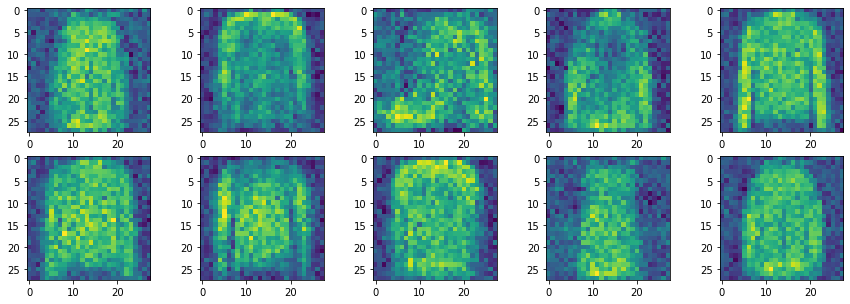

In [15]:
generator.eval()
with torch.no_grad():
  noise = torch.randn((10, generator.input_size)).to(device)
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].view(28,28).cpu()
      _ax.imshow(img)
      i+=1
  plt.show()

Si bien hemos podido implementar el bucle de entrenamiento de una *GAN* nuestro modelo sencillo no es capaz de producir buenas imágenes. Para ello necesitamos un tipo de red neuronal especialmente diseñada para trabajar con imágenes, y que ya conocemos de posts anteriores: redes convolucionales.

## DCGANs

Podemos usar *DCGANs* (*deep convolutional GANs*) para obtener mejores generadores utilizando redes convolucionales. En este caso, necesitaremos arquitecturas diferentes para generador y discriminador.

![](https://gluon.mxnet.io/_images/dcgan.png)

El generador recibirá un vector de 100 valores aleatorios y después aplicaremos varias capas de convoluciones transpuestas (que aumentarán el tamaño de los mapas de caracterísitcas, como hicimos en nuestras redes para [segmentación](https://sensioai.com/blog/50_cv_segmentacion)) hasta obtener la imagen generada.

In [16]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_size = 100
    self.inp = nn.Sequential(
        nn.Linear(self.input_size, 7*7*128),
        nn.BatchNorm1d(7*7*128),
    )
    self.main = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )

  def forward(self, x):
    x = self.inp(x)
    x = x.view(-1, 128, 7, 7)
    x = self.main(x)
    x = x.view(x.size(0), 28*28)
    return x

In [17]:
generator = Generator()
output = generator(torch.randn(64, 100))
output.shape

torch.Size([64, 784])

Al final del generador usamos una activación `tanh`, que dará valores entre -1 y 1. Por este motivo tenemos que re-normalizar nuestras imágenes en el dataset.

In [18]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, trainset):
    self.imgs = torch.tensor([np.array(i[0]).flatten() / 255. for i in trainset], dtype=torch.float, device=device)
    self.imgs = self.imgs * 2. - 1.
    self.labels = torch.tensor([i[1] for i in trainset], dtype=torch.long, device=device)

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, ix):
    return self.imgs[ix], self.labels[ix]

train = Dataset(trainset)
len(train)

60000

In [19]:
img, label = train[0]
img.shape, img.dtype, img.max(), img.min()

(torch.Size([784]),
 torch.float32,
 tensor(1., device='cuda:0'),
 tensor(-1., device='cuda:0'))

In [20]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([32, 784]), torch.Size([32]))

En cuanto al discriminador, utilizaremos una `CNN` típica como las que conocemos cuando hacemos clasificación de imagen.

In [21]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
        nn.Conv2d(1, 64, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True)
    )
    self.out = nn.Sequential(
        nn.Linear(128*7*7, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    # esperamos vectores a la entrada de 28*28
    x = x.view(x.size(0), 1, 28, 28)
    x = self.main(x)
    x = x.view(x.size(0), -1)
    x = self.out(x)
    return x

In [22]:
discriminator = Discriminator()
output = discriminator(torch.randn(64, 28*28))
output.shape

torch.Size([64, 1])

Ahora podemos utilizar exactamente el mismo bucle de entrenamiento anterior para obtener un nuevo generador.

In [23]:
hist = fit(generator, discriminator, dataloader, crit=torch.nn.BCELoss())

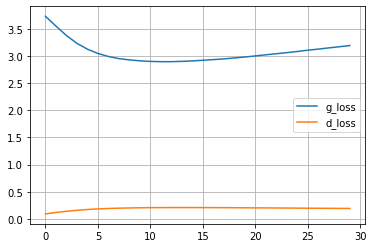

In [24]:
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

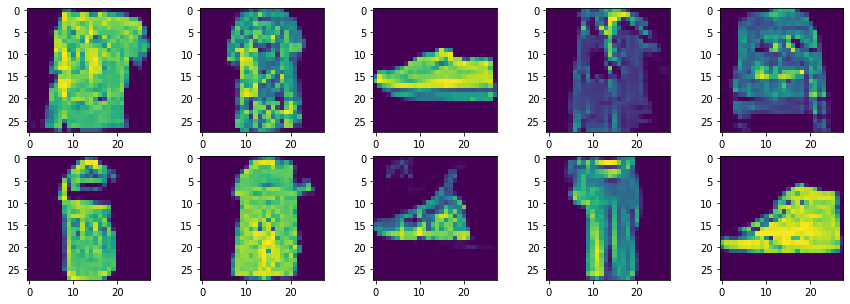

In [25]:
generator.eval()
with torch.no_grad():
  noise = torch.randn((10, generator.input_size)).to(device)
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].view(28,28).cpu()
      _ax.imshow(img)
      i+=1
  plt.show()

En este caso las imágenes generadas son un poco mejores que las que obteníamos con la *GAN* simple, aunque todavía hay márgen de mejora.

> ⚡¿Te ves capaz de utilizar este código como base para entrenar una *GAN* capaz de generar caras realistas? Para ello puedes utilizar el dataset [CelebA](https://pytorch.org/docs/stable/torchvision/datasets.html#celeba)

## Resumen

En este post hemos aprendido a implementar *GANs*, redes neuronales capaces de generar datos similares a los usados en el entrenamiento, en este caso imágenes. Este tipo de arquitecturas están formadas por dos redes neuronales que compiten entre sí durante el entrenamiento: el generador y el discriminador. El generador se encarga de generar imágenes falsas a partir de un vector de valores aleatorios, que se puede interpretar como una versión comprimida de la imagen, mientras que el discriminador se encarga de distinguir entre imágenes reales, obtenidas del dataset, y falsas, generadas por el generador. Una vez entrenado el modelo, descartamos el discriminador y nos quedamos con el generador que será capaz de generar imágenes realistas, similares a la usadas en el dataset. Este tipo de modelos se utilizan para generar caras de gente que no existe, colorear imágenes en blanco y negro, generar imágenes realistas a partir de máscaras de segmentación, incluso los famosos *deep fakes*.